In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'mauredtha'
os.environ['KAGGLE_KEY'] = '1b69ee3fc0d0432e569d437704413747'

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

 98% 340M/346M [00:03<00:00, 131MB/s]
100% 346M/346M [00:03<00:00, 118MB/s]


In [ ]:
!unzip -q intel-image-classification.zip -d .

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_path = 'seg_train/seg_train'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=20,
        zoom_range=0.2,
        shear_range=0.2,
        validation_split=0.2,
        fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
        data_path,
        target_size=(224,224),  # ganti resolusi
        batch_size=32,
        subset='training', 
        class_mode='categorical',
        shuffle=True,
        )  
  
validation_generator = train_datagen.flow_from_directory(
        data_path,
        target_size=(224,224), # ganti resolusi
        batch_size=32,
        subset='validation',
        class_mode='categorical',
        shuffle=False,
        )

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop


#model_resnet = ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3)))
#model_resnet.layers[0].trainable = False
#model_resnet.summary()

#MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))

model_base = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

model = tf.keras.models.Sequential([
    model_base,
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax') 
])

model.compile(loss='categorical_crossentropy',optimizer=RMSprop(lr=1e-4), metrics=['accuracy'])
#rmsprop
#RMSprop(lr=0.001) RMSprop(lr=1e-4)
#tf.optimizers.Adam()

#callbacks
#early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
checkpoint =ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1)  

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
conv2d_407 (Conv2D)          (None, 5, 5, 32)          442400    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_408 (Conv2D)          (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)               

In [ ]:
history =  model.fit(
      train_generator,
      epochs=50,
      steps_per_epoch  = 10,
      validation_data=validation_generator,
      validation_steps = 10,
      callbacks=[checkpoint], #early_stop
      verbose=1)

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.7567 - accuracy: 0.2500 
Epoch 00001: val_accuracy improved from -inf to 0.23125, saving model to best_model.h5
10/10 [==============================] - 370s 37s/step - loss: 1.7567 - accuracy: 0.2500 - val_loss: 1.4128 - val_accuracy: 0.2313
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.4435 - accuracy: 0.4625 
Epoch 00002: val_accuracy improved from 0.23125 to 0.33125, saving model to best_model.h5
10/10 [==============================] - 366s 37s/step - loss: 1.4435 - accuracy: 0.4625 - val_loss: 1.2574 - val_accuracy: 0.3313
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.0801 - accuracy: 0.6062 
Epoch 00003: val_accuracy improved from 0.33125 to 0.51875, saving model to best_model.h5
10/10 [==============================] - 365s 36s/step - loss: 1.0801 - accuracy: 0.6062 - val_loss: 1.0053 - val_accuracy: 0.5188
Epoch 4/50
10/10 [==============================] - ETA

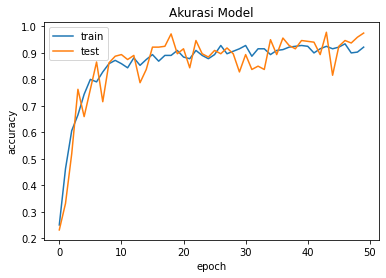

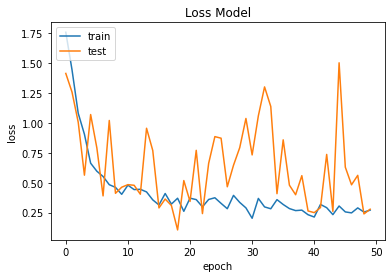

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp12_ihfvs/assets


INFO:tensorflow:Assets written to: /tmp/tmp12_ihfvs/assets


In [ ]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)